## Video Pretraining

Requires outputs from `imageclef_separate_arrays.ipynb`

In [1]:
!nvidia-smi

Mon Apr 26 07:04:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
colab = True
if colab:
    # Mount drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # Set path to working directory
    import sys
    sys.path.append('/content/gdrive/My Drive/ImageCLEF2021/')
    %cd /content/gdrive/My\ Drive/ImageCLEF2021/

Mounted at /content/gdrive
/content/gdrive/My Drive/ImageCLEF2021


In [3]:
import time
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score


ROOT_DIR = os.path.abspath("./")
CFG_NAME = "video_pretraining"
PRETRAINED_MODEL = "vgg_lstm_10_sgd_tf24"
PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR, "logs", PRETRAINED_MODEL)
LOG_PATH = os.path.join(ROOT_DIR, "logs", CFG_NAME)

DATASET_PATH = os.path.join(ROOT_DIR, "dataset/")
VOLUMES_PATH = os.path.join(DATASET_PATH, "ct_volumes")
LABEL_PATH = os.path.join(DATASET_PATH, "ct_labels.npy")

# Make logs directory, dump all experiment results inside this sub folder
if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))

# Make new directory for the current experiment
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

# Class names
classes = ['Infiltrative', 'Focal', 'Tuberculoma', 'Miliary', 'Fibro-cavernous']

## Helpers

In [4]:
def compute_accuray_kappa_score(y1, y2):
    """Computes acc and kappa scores
    y1 : (N,) shape of labels
    y2 : (N,) shape of predicted labels
    """
    # Accuracy
    acc = accuracy_score(y1, y2) * 100
    print("Accuracy : {:.3f}".format(acc)) 

    # Kappa 
    # -1 to 1, 1 means complete agreement
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html
    # https://stackoverflow.com/questions/43676905/how-to-calculate-cohens-kappa-coefficient-that-measures-inter-rater-agreement
    kappa = cohen_kappa_score(y1, y2)
    print("Kappa Score : {:.3f}".format(kappa))


def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    plt.show()

    # loss = history.history['accuracy']
    # val_loss = history.history['val_accuracy']
    # epochs = range(len(loss))
    # plt.plot(epochs, loss, 'r')
    # plt.plot(epochs, val_loss, 'b')
    # #plt.title('Training and validation accuracy')
    # plt.ylabel('Accuracy %')
    # plt.xlabel('Epoch')
    # plt.legend(['train', 'val'], loc='lower right')
    # plt.grid(True)
    # plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, CFG_NAME), dpi=100)
    # plt.show()


def plot_slices(num_rows, num_columns, width, height, channels, video):
    """Plot a montage of slices"""
    data = video.copy()
    #data = np.rot90(np.array(data))
    #data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height, channels))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    ct = 1
    for i in range(rows_data):
        for j in range(columns_data):
            font = cv2.FONT_HERSHEY_COMPLEX  #press tab for different operations
            img = np.dstack((data[i][j], data[i][j], data[i][j]))
            img = cv2.resize(img, (64, 64))
            cv2.putText(img, str(ct), (3,15), font, 0.5, (0,255,0), 1, cv2.LINE_AA)
            axarr[i, j].imshow(img, cmap="gray")
            axarr[i, j].axis("off")
            ct+=1
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

### Dataset class and loader

In [6]:
import keras

from scipy import ndimage
from sklearn.model_selection import train_test_split

# Classes for data loading and preprocessing
class ImageCLEFNumPyDataset:
    def __init__(
            self, 
            datadir, 
            label_path,
            flag,
    ):

        def get_number(filename):
          return int(filename[:filename.find('.')])
        
        def sort_paths(paths):
          paths.sort(key = get_number)
          return paths

        # Patient names in folder
        # 1.npy, 2.npy, 3.npy etc.
        self.ids = sort_paths(os.listdir(datadir))
        
        # Sorted patient names in folder
        self.images_fps = [os.path.join(datadir, image_id) for image_id in self.ids]
        
        # Get labels
        self.labels = np.load(label_path)
        
        assert len(self.labels) == len(self.images_fps), print("Should be same!")

        # Split data
        train_vols, test_vols, train_labels, test_labels = train_test_split(self.images_fps, 
                                                                            self.labels, test_size=0.20, 
                                                                            random_state=0, 
                                                                            stratify=self.labels)
        print("Training data samples:", len(train_vols))
        print("Validation data samples:", len(test_vols))

        unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
        print("Train split: ", dict(zip(unique, counts)))

        unique, counts = np.unique(np.argmax(test_labels, axis=1), return_counts=True)
        print("Validation split: ", dict(zip(unique, counts)))

        
        self.train_vols = train_vols
        self.test_vols = test_vols
        self.train_labels = train_labels
        self.test_labels = test_labels
        
        if flag == "train":
            self.images_fps = self.train_vols
            self.labels = self.train_labels
            self.ids = self.train_vols
            
        else:
            self.images_fps = self.test_vols
            self.labels = self.test_labels
            self.ids = self.test_vols
        
        
    def __getitem__(self, i):
        
        # Read data
        img = np.load(self.images_fps[i])
        #img = img * 255.0

        # Get labels
        gt = self.labels[i] # one-hot encoded already

        # If not, use the code below.
        # One-hot encode labeks
        #gt = np.squeeze(np.eye(5)[gt.reshape(-1)])

        return img, gt
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        # Newer TF requires data type to be tuple and not list
        # https://github.com/qubvel/segmentation_models/issues/412
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [7]:
train_dataset = ImageCLEFNumPyDataset(VOLUMES_PATH,
                                      LABEL_PATH,
                                      flag="train")

Training data samples: 732
Validation data samples: 184
Train split:  {0: 335, 1: 180, 2: 81, 3: 80, 4: 56}
Validation split:  {0: 84, 1: 46, 2: 20, 3: 20, 4: 14}


In [8]:
valid_dataset = ImageCLEFNumPyDataset(VOLUMES_PATH,
                                      LABEL_PATH,
                                      flag="val")

Training data samples: 732
Validation data samples: 184
Train split:  {0: 335, 1: 180, 2: 81, 3: 80, 4: 56}
Validation split:  {0: 84, 1: 46, 2: 20, 3: 20, 4: 14}


In [9]:
image, gt = train_dataset[2] 
image.shape, gt.shape

((70, 224, 224, 1), (5,))

In [10]:
np.min(image), np.max(image)

(0.0, 1.0)

In [11]:
np.unique(image)

array([0.0000000e+00, 1.4012985e-45, 2.8025969e-45, ..., 9.9999976e-01,
       9.9999982e-01, 1.0000000e+00], dtype=float32)

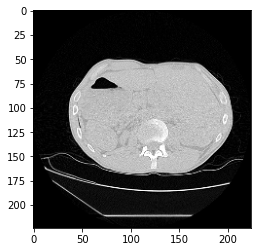

In [12]:
plt.imshow(np.squeeze(image[0]), cmap='gray')

CT Type: Miliary.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

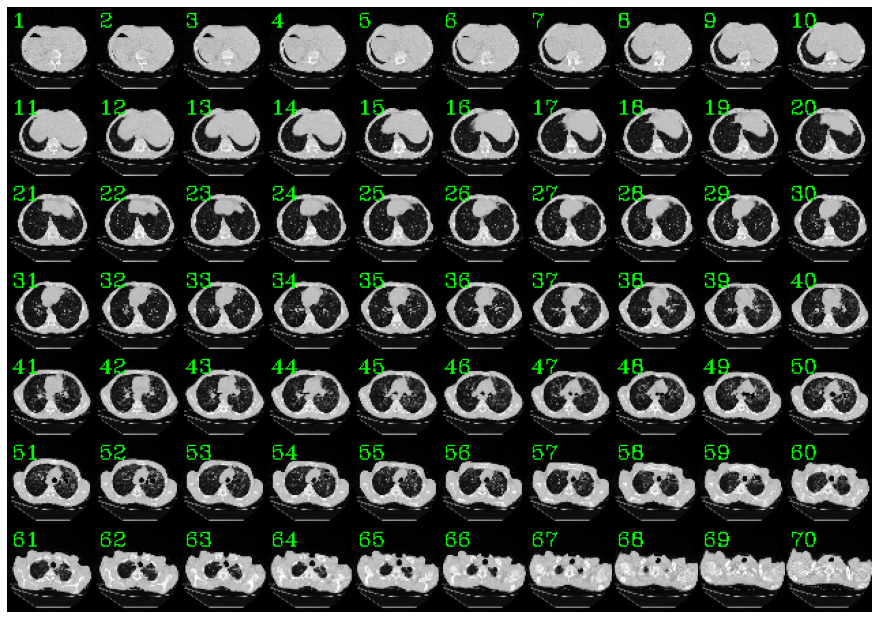

In [13]:
# Visualize montage of slices.

idx = np.argmax(gt)
print("CT Type: {}.".format(classes[idx]))
plot_slices(7, 10, 224, 224, 1, image)

In [14]:
train_dataloader = Dataloder(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [15]:
# Test train loader
x , y = next(iter(train_dataloader))
print(x.shape, y.shape)

(2, 70, 224, 224, 1) (2, 5)


### Models

In [16]:
def convlstm():
  """Stupid model"""
  seq_len, img_height, img_width = 70, 64, 64
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 1)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(6, activation = "softmax"))
  # Compile model
  optimizer = tf.keras.optimizers.SGD(lr=0.001)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  return model


def vgg_lstm():
  """Somewhat better"""
  # define input D, W, H, 1
  video = tf.keras.layers.Input(shape=(seq_len,
                      img_height,
                      img_width,
                      1))
  
  # map N channels data to 3 channels for input to CNN
  layer_3d = tf.keras.layers.Conv3D(3, (1, 1, 1))(video) 
  # define base model for feature extraction
  cnn_base = tf.keras.applications.VGG16(input_shape=(img_height,
                                img_width,
                                3),
                  weights="imagenet",
                  include_top=False)
  cnn_out = tf.keras.layers.GlobalAveragePooling2D()(cnn_base.output)
  cnn = tf.keras.Model(inputs=cnn_base.input, outputs=cnn_out)
  cnn.trainable = False

  # video frames go through cnn and then to lstm
  encoded_frames = tf.keras.layers.TimeDistributed(cnn)(layer_3d)
  print(encoded_frames)
  encoded_sequence = tf.keras.layers.LSTM(256)(encoded_frames)
  hidden_layer = tf.keras.layers.Dense(1024, activation="relu")(encoded_sequence)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(hidden_layer)
  model = tf.keras.Model([video], outputs)

  optimizer = tf.keras.optimizers.SGD(lr=0.001)
  # optimizer = tf.keras.optimizers.Nadam(lr=0.002,
  #                   beta_1=0.9,
  #                   beta_2=0.999,
  #                   epsilon=1e-08,
  #                   schedule_decay=0.004)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  return model


def vgg_lstm_4096():
  """More better, maybe? Test it out.
  Try GRUs next.
  """
  # define input D, W, H, 1
  video = tf.keras.layers.Input(shape=(seq_len,
                      img_height,
                      img_width,
                      1))
  
  # map N channels data to 3 channels for input to CNN
  layer_3d = tf.keras.layers.Conv3D(3, (1, 1, 1))(video) 
  # define base model for feature extraction
  cnn_base = tf.keras.applications.VGG16(input_shape=(img_height,
                                img_width,
                                3),
                  weights="imagenet",
                  include_top=True) # set to True, when using 4096-d f.v
  cnn = tf.keras.Model(inputs=cnn_base.input, outputs=cnn_base.layers[-3].output)
  cnn.trainable = False
  
  # video frames go through cnn and then to lstm
  encoded_frames = tf.keras.layers.TimeDistributed(cnn)(layer_3d)
  print(encoded_frames)
  encoded_sequence = tf.keras.layers.LSTM(256)(encoded_frames)
  hidden_layer = tf.keras.layers.Dense(1024, activation="relu")(encoded_sequence)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(hidden_layer)
  model = tf.keras.Model([video], outputs)
  optimizer = tf.keras.optimizers.Nadam(lr=0.002,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-08,
                    schedule_decay=0.004)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  return model


def pretrained_model(): 
  # Load pretrained model
  pretrained = load_model("{}/{}.h5".format(PRETRAINED_MODEL_PATH, PRETRAINED_MODEL))
  x = pretrained.layers[-2].output
  outputs = tf.keras.layers.Dense(5, activation="softmax", name='final_output')(x)
  model = tf.keras.Model([pretrained.input], outputs)
  # Compile model
  optimizer = tf.keras.optimizers.SGD(lr=0.001)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer, 
                metrics=[tf.keras.metrics.AUC()])
  return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 224, 224, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 70, 224, 224, 3)   6         
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 512)           14714688  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
final_output (Dense)         (None, 5)                 5125      
Total params: 15,770,443
Trainable params: 1,055,755
Non-trainable params: 14,714,688
_________________________________________

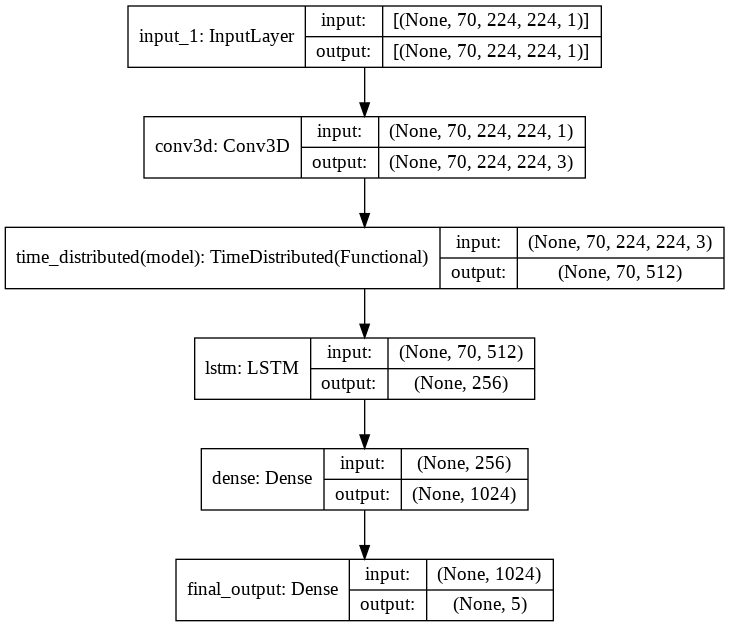

In [17]:
# Callbacks
earlystop = tf.keras.callbacks.EarlyStopping(patience=8,
                          verbose=1,
                          restore_best_weights=True)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.1, 
                                             verbose=1, 
                                             patience=5, 
                                             mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="{}/{}.h5".format(LOG_PATH, CFG_NAME),
                                            monitor='val_loss',
                                            mode='min',
                                            verbose=1,
                                            save_best_only=True)
callbacks = [earlystop, reducelr, checkpoint]

# Create model
model = None
model = pretrained_model()
print(model.summary())
tf.keras.utils.plot_model(model, to_file='{}/tbt_classification.png'.format(LOG_PATH), show_shapes=True, show_layer_names=True)

Training model.
Epoch 1/100
366/366 [==============================] - 1007s 3s/step - loss: 1.4081 - auc_1: 0.7106 - val_loss: 1.3853 - val_auc_1: 0.7338

Epoch 00001: val_loss improved from inf to 1.38527, saving model to /content/gdrive/My Drive/ImageCLEF2021/logs/video_pretraining/video_pretraining.h5
Epoch 2/100
366/366 [==============================] - 235s 641ms/step - loss: 1.3710 - auc_1: 0.7265 - val_loss: 1.3909 - val_auc_1: 0.7376

Epoch 00002: val_loss did not improve from 1.38527
Epoch 3/100
366/366 [==============================] - 235s 642ms/step - loss: 1.3636 - auc_1: 0.7350 - val_loss: 1.3849 - val_auc_1: 0.7392

Epoch 00003: val_loss improved from 1.38527 to 1.38491, saving model to /content/gdrive/My Drive/ImageCLEF2021/logs/video_pretraining/video_pretraining.h5
Epoch 4/100
366/366 [==============================] - 235s 641ms/step - loss: 1.4270 - auc_1: 0.6992 - val_loss: 1.3799 - val_auc_1: 0.7430

Epoch 00004: val_loss improved from 1.38491 to 1.37986, savin

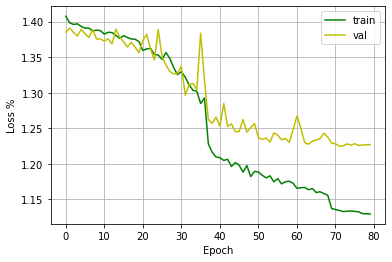

In [16]:
start_time = time.time()

print("Training model.")
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=100, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),  # samples = batch size * no of steps
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
plot_loss_accu(history)

### Test model

In [18]:
model = None
model = load_model("{}/{}.h5".format(LOG_PATH, CFG_NAME), compile = False)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 224, 224, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 70, 224, 224, 3)   6         
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 512)           14714688  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
final_output (Dense)         (None, 5)                 5125      
Total params: 15,770,443
Trainable params: 1,055,755
Non-trainable params: 14,714,688
_______________________________________

In [19]:
y_pred = []
y_test = []

for batch_idx, (features, targets) in enumerate(valid_dataloader):
    print(batch_idx, features.shape, targets.shape)
    y_pred.append(model.predict(features))
    y_test.append(targets[0])

y_pred = np.array(y_pred)
y_pred = np.squeeze(y_pred)

0 (1, 70, 224, 224, 1) (1, 5)
1 (1, 70, 224, 224, 1) (1, 5)
2 (1, 70, 224, 224, 1) (1, 5)
3 (1, 70, 224, 224, 1) (1, 5)
4 (1, 70, 224, 224, 1) (1, 5)
5 (1, 70, 224, 224, 1) (1, 5)
6 (1, 70, 224, 224, 1) (1, 5)
7 (1, 70, 224, 224, 1) (1, 5)
8 (1, 70, 224, 224, 1) (1, 5)
9 (1, 70, 224, 224, 1) (1, 5)
10 (1, 70, 224, 224, 1) (1, 5)
11 (1, 70, 224, 224, 1) (1, 5)
12 (1, 70, 224, 224, 1) (1, 5)
13 (1, 70, 224, 224, 1) (1, 5)
14 (1, 70, 224, 224, 1) (1, 5)
15 (1, 70, 224, 224, 1) (1, 5)
16 (1, 70, 224, 224, 1) (1, 5)
17 (1, 70, 224, 224, 1) (1, 5)
18 (1, 70, 224, 224, 1) (1, 5)
19 (1, 70, 224, 224, 1) (1, 5)
20 (1, 70, 224, 224, 1) (1, 5)
21 (1, 70, 224, 224, 1) (1, 5)
22 (1, 70, 224, 224, 1) (1, 5)
23 (1, 70, 224, 224, 1) (1, 5)
24 (1, 70, 224, 224, 1) (1, 5)
25 (1, 70, 224, 224, 1) (1, 5)
26 (1, 70, 224, 224, 1) (1, 5)
27 (1, 70, 224, 224, 1) (1, 5)
28 (1, 70, 224, 224, 1) (1, 5)
29 (1, 70, 224, 224, 1) (1, 5)
30 (1, 70, 224, 224, 1) (1, 5)
31 (1, 70, 224, 224, 1) (1, 5)
32 (1, 70, 224, 22

In [20]:
len(y_pred), len(y_test)

(184, 184)

In [21]:
# Flatten
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
assert y_pred.shape == y_test.shape, "Should be same!"

In [22]:
%%capture cap --no-stderr
compute_accuray_kappa_score(y_test, y_pred)
print("\n")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
with open('{}/test_results.txt'.format(LOG_PATH), 'w') as f:
    f.write(cap.stdout)

In [24]:
print("Done!")

Done!
